# AirQualityUCI 데이터 전처리 및 시각화
이 노트북은 Air Quality UCI 데이터셋을 불러오고, 전처리 및 시각화를 수행

In [10]:
# 1. 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 2. 데이터 불러오기
df = pd.read_csv("AirQualityUCI.csv", sep=';', decimal=',')

In [12]:
# 3. 마지막 빈 열 제거 + 결측 행 제거
df = df.dropna(how='all', axis=1)
df = df.dropna()

In [13]:
# 4. 날짜-시간 합치기
df["Time"] = df["Time"].astype(str).str.replace(".", ":", regex=False)
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True, errors='coerce')
df = df.dropna(subset=["Datetime"])  # 날짜 파싱 실패한 행 제거
df = df.set_index("Datetime")
df = df.drop(columns=["Date", "Time"])

In [14]:
# 5. 정수 변환 및 결측치(-200) 제거
df = df.apply(pd.to_numeric, errors='coerce')
df[df == -200] = pd.NA
df = df.dropna()

In [15]:
# 6. 데이터 미리보기
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


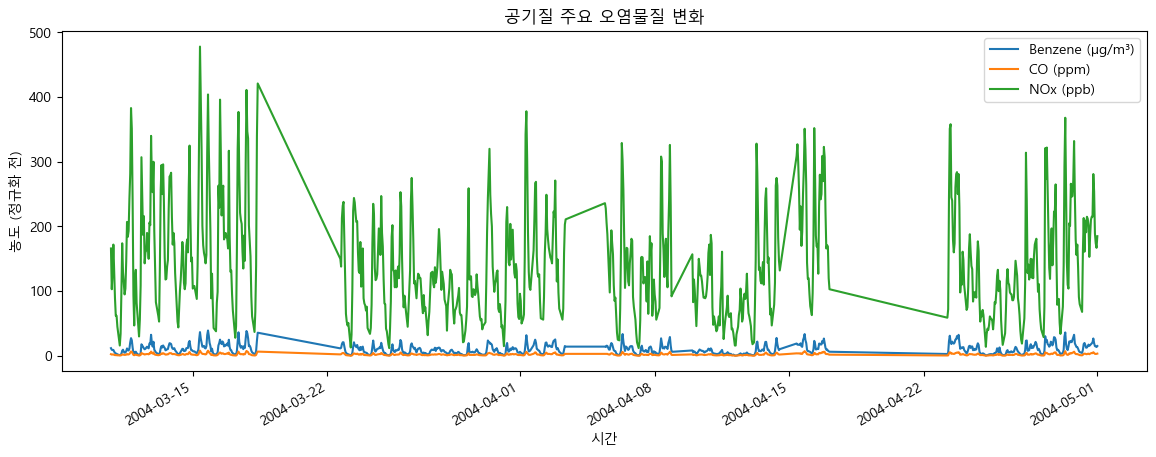

In [16]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 7. 시간 흐름에 따른 주요 센서 및 실제 값 시각화
plt.figure(figsize=(14, 5))
df["C6H6(GT)"].plot(label="Benzene (µg/m³)")
df["CO(GT)"].plot(label="CO (ppm)")
df["NOx(GT)"].plot(label="NOx (ppb)")
plt.legend()
plt.title("공기질 주요 오염물질 변화")
plt.xlabel("시간")
plt.ylabel("농도 (정규화 전)")
plt.show()

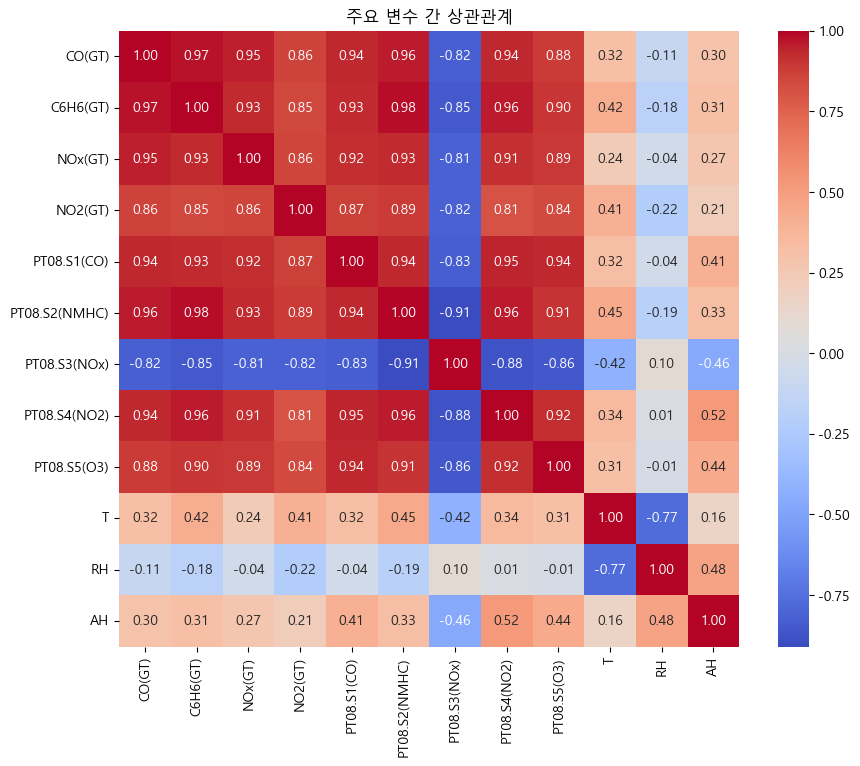

In [17]:
# 8. 주요 변수들 간의 상관관계 행렬
features_of_interest = [
    "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)",
    "PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)",
    "T", "RH", "AH"
]

corr = df[features_of_interest].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("주요 변수 간 상관관계")
plt.show()

In [22]:

# 모델 정의
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt

def build_lstm(input_shape):
    model = Sequential([LSTM(64, input_shape=input_shape), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([GRU(64, input_shape=input_shape), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [23]:

# 모델 학습 및 평가 함수
def train_and_eval(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=50, verbose=0)
    return model.evaluate(X_test, y_test, verbose=0)

# 시계열 시퀀스 생성 함수
def create_sequences(data, input_features, target_feature, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x = data[input_features].iloc[i:i + window_size].values
        seq_y = data[target_feature].iloc[i + window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 입력 변수 그룹 정의
high_corr_features = ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']
low_corr_features = ['T', 'RH', 'AH']
target = 'C6H6(GT)'

# 시퀀스 생성
X_high, y_high = create_sequences(df, high_corr_features, target)
X_low, y_low = create_sequences(df, low_corr_features, target)

# 학습/테스트 분리 함수
def split_data(X, y, train_ratio=0.8):
    split = int(len(X) * train_ratio)
    return X[:split], X[split:], y[:split], y[split:]

# High Corr 데이터 분할
Xh_train, Xh_test, yh_train, yh_test = split_data(X_high, y_high)

# Low Corr 데이터 분할
Xl_train, Xl_test, yl_train, yl_test = split_data(X_low, y_low)


In [24]:

# 모델 성능 측정
results = {}
results['LSTM - High Corr'] = train_and_eval(build_lstm(Xh_train.shape[1:]), Xh_train, yh_train, Xh_test, yh_test)
results['LSTM - Low Corr'] = train_and_eval(build_lstm(Xl_train.shape[1:]), Xl_train, yl_train, Xl_test, yl_test)
results['GRU - High Corr'] = train_and_eval(build_gru(Xh_train.shape[1:]), Xh_train, yh_train, Xh_test, yh_test)
results['GRU - Low Corr'] = train_and_eval(build_gru(Xl_train.shape[1:]), Xl_train, yl_train, Xl_test, yl_test)
results['1D-CNN - High Corr'] = train_and_eval(build_cnn(Xh_train.shape[1:]), Xh_train, yh_train, Xh_test, yh_test)
results['1D-CNN - Low Corr'] = train_and_eval(build_cnn(Xl_train.shape[1:]), Xl_train, yl_train, Xl_test, yl_test)
results


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'LSTM - High Corr': 49.042049407958984,
 'LSTM - Low Corr': 52.79999923706055,
 'GRU - High Corr': 53.67691421508789,
 'GRU - Low Corr': 42.06416320800781,
 '1D-CNN - High Corr': 90.91070556640625,
 '1D-CNN - Low Corr': 44.18974304199219}

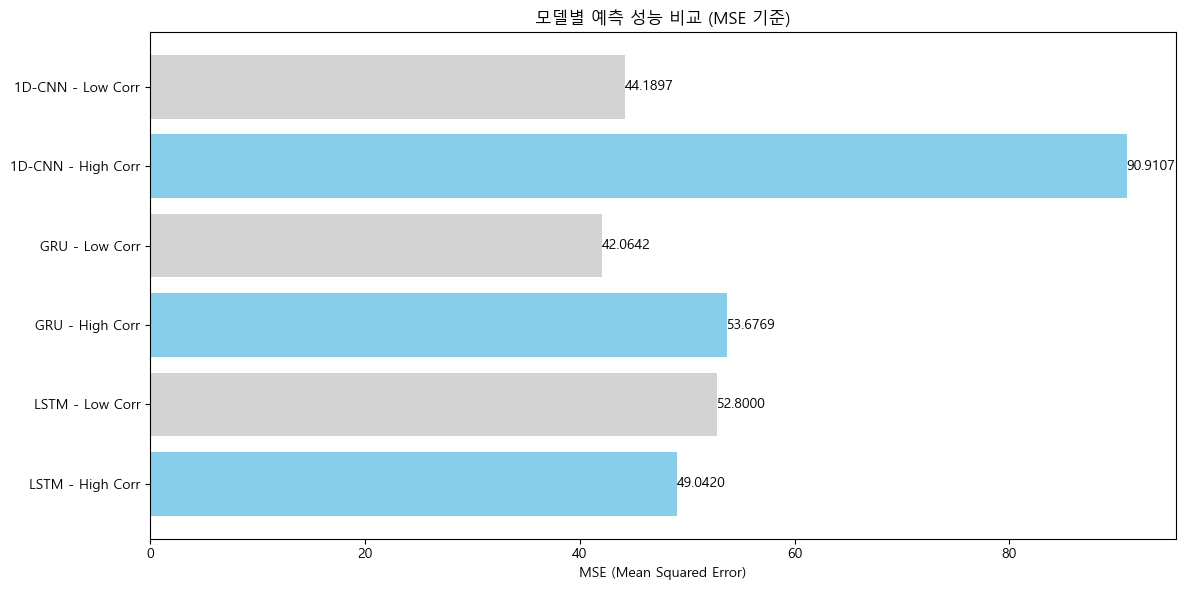

In [25]:

# 시각화
labels = list(results.keys())
mse_vals = list(results.values())
colors = ['skyblue' if 'High' in label else 'lightgray' for label in labels]

plt.figure(figsize=(12, 6))
bars = plt.barh(labels, mse_vals, color=colors)
for bar in bars:
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.4f}", va='center')
plt.title("모델별 예측 성능 비교 (MSE 기준)")
plt.xlabel("MSE (Mean Squared Error)")
plt.tight_layout()
plt.show()
